--- Setting up the environment ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Analyzing and organizing images in: /content/drive/MyDrive/VirtualFIT_Models/datasets/test/agnostic-v3.2 ---


Processing Images:   0%|          | 0/2032 [00:00<?, ?it/s]


--- Final File Organization Summary ---
Fair: 664 images
Brown: 1147 images
Dark: 76 images
Failed/Not Detected: 145 images
---------------------------------------------

--- Visual Verification (Random Samples from New Folders) ---


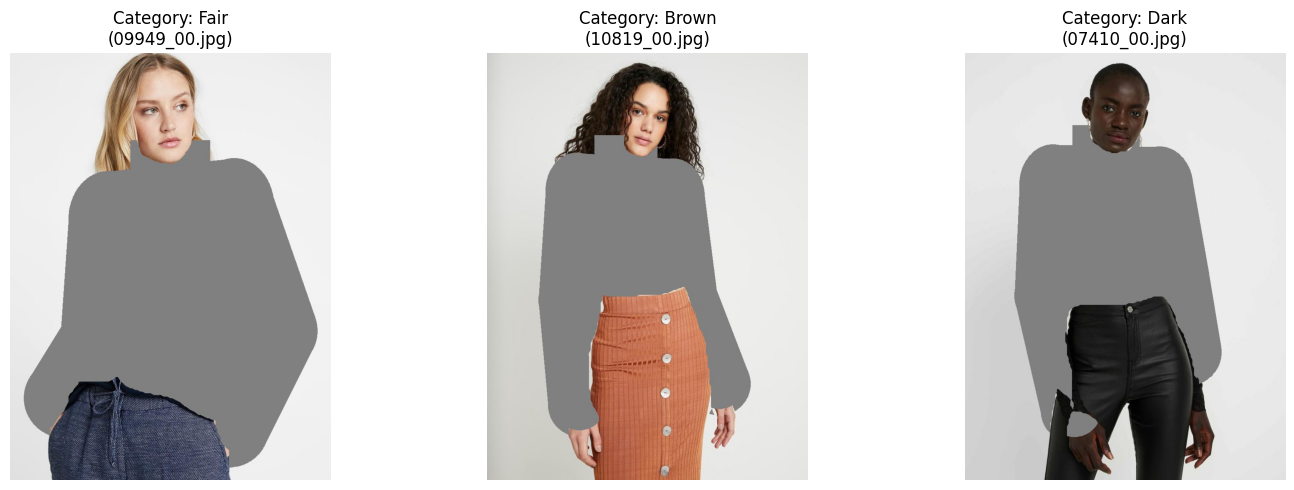

In [3]:
import os
import cv2
import numpy as np
from google.colab import drive
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

# ==============================================================================
#                                   PART 1: SETUP
# ==============================================================================
print("--- Setting up the environment ---")
drive.mount('/content/drive')

# MODIFIED: Pointing to the new, larger dataset directory
IMAGE_DIR = '/content/drive/MyDrive/VirtualFIT_Models/datasets/test/agnostic-v3.2'

# Path to OpenCV's pre-trained face detector
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

if not os.path.exists(IMAGE_DIR):
    raise FileNotFoundError(f"The specified folder was not found: {IMAGE_DIR}")

# Create the destination folders for each category
FAIR_DIR = os.path.join(IMAGE_DIR, 'Fair')
BROWN_DIR = os.path.join(IMAGE_DIR, 'Brown')
DARK_DIR = os.path.join(IMAGE_DIR, 'Dark')
FAILED_DIR = os.path.join(IMAGE_DIR, 'Failed_Detection')

for d in [FAIR_DIR, BROWN_DIR, DARK_DIR, FAILED_DIR]:
    os.makedirs(d, exist_ok=True)

# ==============================================================================
#                  PART 2: DEFINE THE ADVANCED ANALYSIS FUNCTION
# ==============================================================================

def analyze_and_categorize_skin(image_path):
    """
    Analyzes an image to detect a face and categorize its skin tone based on
    the L*a*b* color space (Lightness).
    """
    try:
        # Load the image with OpenCV
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            return "Could not read image", None

        # Convert to grayscale for the face detector
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        if len(faces) == 0:
            return "No face detected", None

        # Use the largest detected face
        (x, y, w, h) = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]

        # Crop the image to just the face
        face_roi_bgr = img_bgr[y:y+h, x:x+w]

        # Convert the cropped face to the CIE LAB color space
        face_roi_lab = cv2.cvtColor(face_roi_bgr, cv2.COLOR_BGR2LAB)

        # Calculate the average L* value (Lightness) across the face
        # We ignore the darkest pixels to avoid hair/shadows
        l_channel = face_roi_lab[:, :, 0]
        # Filter out pure black/gray from the agnostic background
        l_channel_filtered = l_channel[l_channel > 20]
        if l_channel_filtered.size == 0:
             return "No skin pixels found", None

        avg_lightness = np.mean(l_channel_filtered)

        # Categorize based on the Lightness value
        # These thresholds are a good starting point and can be adjusted
        if avg_lightness > 165: # Corresponds to lighter skin tones
            category = "Fair"
        elif avg_lightness > 120: # Corresponds to medium/brown skin tones
            category = "Brown"
        else: # Corresponds to darker skin tones
            category = "Dark"

        return category, face_roi_bgr

    except Exception as e:
        return f"Error: {e}", None

# ==============================================================================
#                 PART 3: PROCESS ALL IMAGES AND ORGANIZE FILES
# ==============================================================================
print(f"\n--- Analyzing and organizing images in: {IMAGE_DIR} ---")

image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

if not image_files:
    print("No images found in the specified directory.")
else:
    # Use tqdm for a progress bar
    for filename in tqdm(image_files, desc="Processing Images"):
        source_path = os.path.join(IMAGE_DIR, filename)
        category, _ = analyze_and_categorize_skin(source_path)

        # Move the file to the appropriate category folder
        if category == "Fair":
            shutil.move(source_path, os.path.join(FAIR_DIR, filename))
        elif category == "Brown":
            shutil.move(source_path, os.path.join(BROWN_DIR, filename))
        elif category == "Dark":
            shutil.move(source_path, os.path.join(DARK_DIR, filename))
        else:
            # Move files where detection failed to a separate folder
            shutil.move(source_path, os.path.join(FAILED_DIR, filename))

    # --- Print the final counts ---
    print("\n--- Final File Organization Summary ---")
    print(f"Fair: {len(os.listdir(FAIR_DIR))} images")
    print(f"Brown: {len(os.listdir(BROWN_DIR))} images")
    print(f"Dark: {len(os.listdir(DARK_DIR))} images")
    print(f"Failed/Not Detected: {len(os.listdir(FAILED_DIR))} images")
    print("-" * 45)

    # --- Visualize a random sample from each category ---
    print("\n--- Visual Verification (Random Samples from New Folders) ---")
    category_dirs = {"Fair": FAIR_DIR, "Brown": BROWN_DIR, "Dark": DARK_DIR}

    plt.figure(figsize=(15, 5))

    for i, (category, dir_path) in enumerate(category_dirs.items()):
        items = os.listdir(dir_path)
        if items:
            # Select a random sample to display
            sample_filename = random.choice(items)
            sample_path = os.path.join(dir_path, sample_filename)

            ax = plt.subplot(1, 3, i + 1)
            # Load with Pillow for correct RGB display in Matplotlib
            img_display = Image.open(sample_path)
            plt.imshow(img_display)
            plt.title(f"Category: {category}\n({sample_filename})")
            plt.axis('off')

    plt.tight_layout()
    plt.show()
